In [80]:
import sys
sys.path.append('../../..')

## Path

In [81]:
import pathlib

PATH_DATASET = pathlib.Path('dataset_2')
PATH_DATASET_NPY = PATH_DATASET / 'npy'
PATH_DATASET_PNG = PATH_DATASET / 'png'


PATH_RESULTS = PATH_DATASET / pathlib.Path('results')
PATH_RESULTS_PNG = PATH_RESULTS / 'png'
PATH_RESULTS_NPY = PATH_RESULTS / 'npy'
PATH_RESULTS_CSV = PATH_RESULTS / 'csv'

if not(PATH_RESULTS.exists()):
    PATH_RESULTS.mkdir()

if not(PATH_RESULTS_PNG.exists()):
    PATH_RESULTS_PNG.mkdir()

if not(PATH_RESULTS_NPY.exists()):
    PATH_RESULTS_NPY.mkdir()

if not(PATH_RESULTS_PNG.exists()):
    PATH_RESULTS_PNG.mkdir()

if not(PATH_RESULTS_CSV.exists()):
    PATH_RESULTS_CSV.mkdir()


## Configure matplotlib

In [82]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = '303030'
matplotlib.rcParams['axes.facecolor'] = '303030'
matplotlib.rcParams['text.color'] = 'FFFFFF'
matplotlib.rcParams['xtick.color'] = 'FFFFFF'
matplotlib.rcParams['ytick.color'] = 'FFFFFF'
matplotlib.rcParams['axes.labelcolor'] = 'FFFFFF'

##  Mumford-Shah

In [83]:
import numpy
import lasp.differential
import lasp.utils
import lasp.filters.linear
import lasp.thresholding

def mumford_shah(
    y: numpy.ndarray, 
    h: numpy.ndarray, 
    alpha: float,
    beta: float,
    sigma: float,
    nb_iterations: int,
    tolerance: float,
    error_history: list[float] = None
) -> numpy.ndarray:

    """Mumford Shah
    
    Solve argmin_{x} { (alpha/2) || y - Hx ||^2 + (beta/2) || nabla y ||^2 + || nabla y ||_1
    """

    Dx = lasp.differential.dx
    Dy = lasp.differential.dy
    Dxt = lasp.differential.dxT
    Dyt = lasp.differential.dyT

    # Build kernel
    uker = numpy.zeros_like(y)

    laplacian = lasp.filters.linear.laplacian()
    lap_diag = lasp.utils.fourier_diagonalization(
        kernel = laplacian,
        shape_out = y.shape 
    )
   
    h_diag = lasp.utils.fourier_diagonalization(
        kernel = h,
        shape_out = y.shape
    )

    h2_diag = numpy.abs(h_diag)**2


    uker = alpha * h2_diag + (beta+sigma) * lap_diag

    rhs1fft = alpha * numpy.conj(h_diag) * numpy.fft.fft2(y)

    # Initialization
    u = numpy.copy(y) 
    d_x=numpy.zeros_like(y)
    d_y=numpy.zeros_like(y)
    b_x=numpy.zeros_like(y)
    b_y=numpy.zeros_like(y)

    for _ in range(0, nb_iterations):

        rhs2 = sigma*Dxt(d_x-b_x)+sigma*Dyt(d_y-b_y)
        rhsfft = rhs1fft + numpy.fft.fft2(rhs2)

        u0=numpy.copy(u)
        
        u = numpy.real(numpy.fft.ifft2(rhsfft / uker))    

        err = numpy.linalg.norm(u-u0, 'fro') / numpy.linalg.norm(u, 'fro')
        
        if not(error_history is None):
            error_history.append(err)

        if err < tolerance:
            break
        
        d_x, d_y = lasp.thresholding.multidimensional_soft(
            d = numpy.array([ Dx(u)+b_x, Dy(u)+b_y ]),
            epsilon = 1/sigma
        )

        b_x=b_x+Dx(u)-d_x
        b_y=b_y+Dy(u)-d_y

    u_normalized = lasp.utils.normalize(u)

    return u_normalized

## Read Dataset

In [84]:
import lasp.filters.linear
import lasp.noise
import lasp.io

import pathlib

import numpy

import scipy.signal
import scipy.io

import matplotlib.pyplot


filenames = list(set(PATH_DATASET_NPY.glob('*.npy')) - set(PATH_DATASET_NPY.glob('kernel.npy')))
filenames.sort()
imgs = [ lasp.io.read(filename).astype(numpy.double) for filename in filenames ]
kernel = lasp.io.read(PATH_DATASET_NPY / 'kernel.npy')

NB_IMAGES = len(filenames)

filenames_original = list(PATH_DATASET_NPY.glob('*Original.npy'))
filenames_original.sort()
filenames_blurred = list(PATH_DATASET_NPY.glob('*Blurred.npy'))
filenames_blurred.sort()
filenames_noised = list(PATH_DATASET_NPY.glob('*Noised.npy'))
filenames_noised.sort()

imgs_original = [ lasp.io.read(file) for file in filenames_original ]
imgs_blurred = [ lasp.io.read(file) for file in filenames_blurred ]
imgs_noised = [ lasp.io.read(file) for file in filenames_noised ]

NB_IMAGES = len(imgs_original)


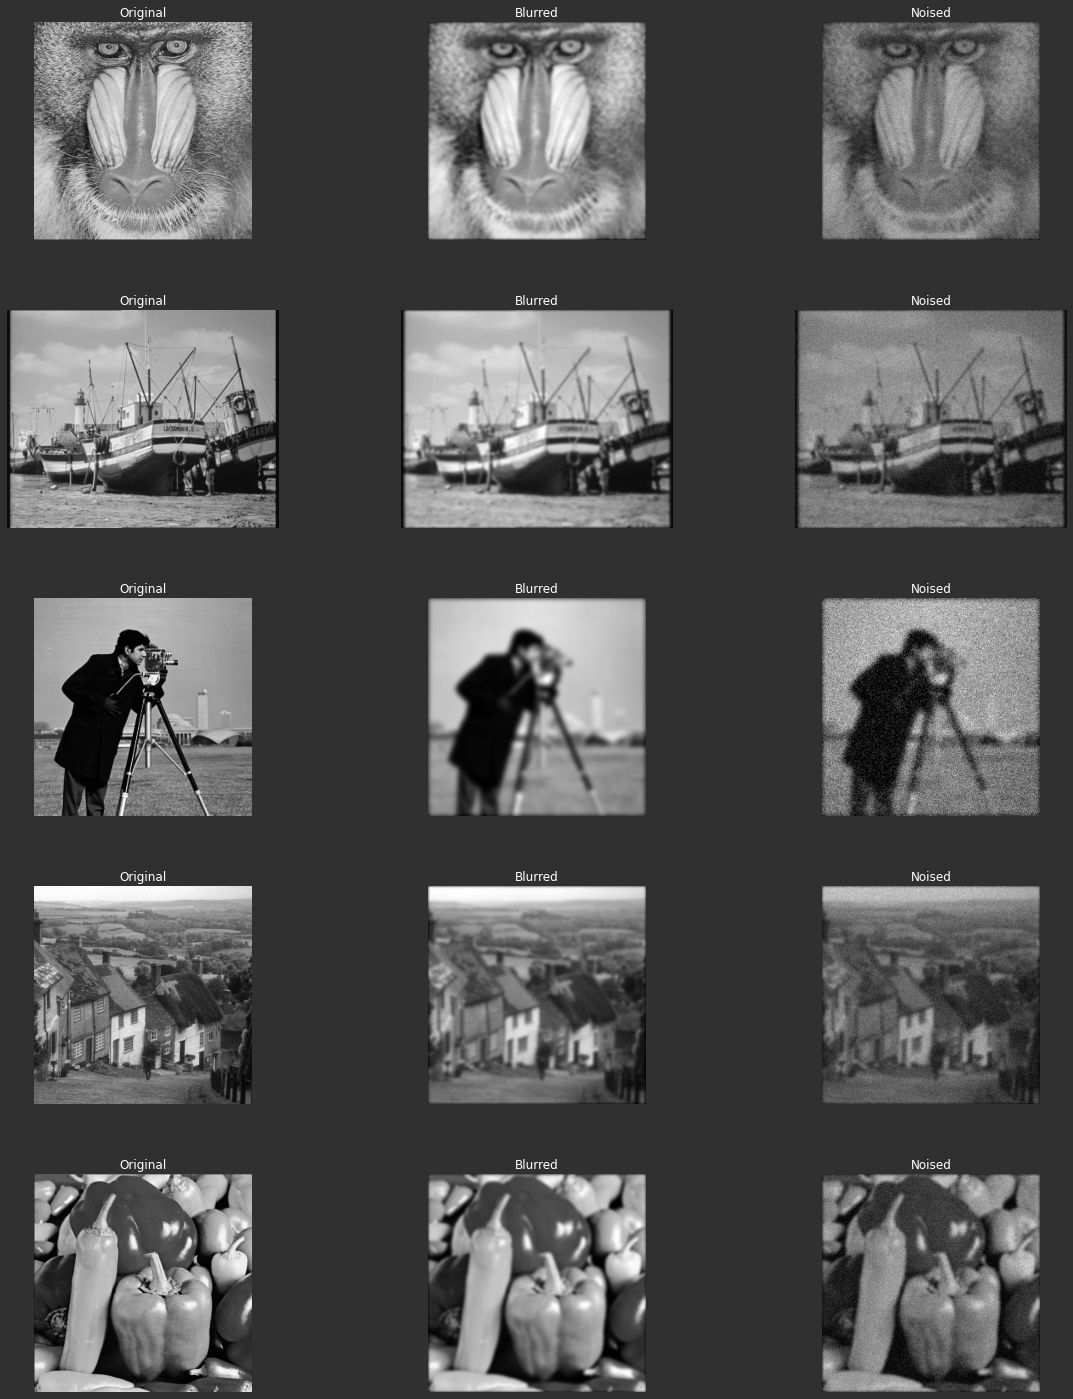

In [85]:
figure = matplotlib.pyplot.figure(figsize=(20, 20))
subfigure = figure.subfigures(NB_IMAGES, 1)

for i in range(0, NB_IMAGES):

    original = imgs_original[i]
    blurred = imgs_blurred[i]
    noised = imgs_noised[i]

    ax = subfigure[i].subplots(1, 3)

    ax[0].axis('off')
    ax[0].set_title('Original')
    ax[0].imshow(original, cmap='gray')

    ax[1].axis('off')
    ax[1].set_title('Blurred')
    ax[1].imshow(blurred, cmap='gray')

    ax[2].axis('off')
    ax[2].set_title('Noised')
    ax[2].imshow(noised, cmap='gray')

figure.savefig(PATH_RESULTS_PNG / 'all_dataset.png')
matplotlib.pyplot.show()

## Process Blurred Images

In [86]:
import lasp.utils
import pandas
import numpy
import numpy.linalg


all_errors_blurred: list[list[float]]= []
dict_errors: dict[str, pandas.Series]= {}
imgs_blurred_results: list[numpy.ndarray] = []

alphas = [ 100, 100, 100, 100, 100]
betas = [ 10, 1, 1, 1, 1 ]
sigmas = [ 2, 2, 2, 2, 2 ]
iterations = [ 300, 300, 300, 300, 300 ]
tols = [ -1, 10**(-4), 10**(-4), 10**(-4), 10**(-4) ]

for i in range(0, NB_IMAGES):

    filename = filenames_blurred[i]
    img = imgs_blurred[i]

    errors = []
    res = mumford_shah(
        y=img,
        h=kernel,
        alpha=alphas[i],
        beta=betas[i],
        sigma=sigmas[i],
        nb_iterations=iterations[i],
        tolerance=tols[i],
        error_history=errors
    )
    
    imgs_blurred_results.append(res)
    img_name = filename.stem
    all_errors_blurred.append(errors)
    dict_errors[img_name] = pandas.Series(errors)

### Check outputs

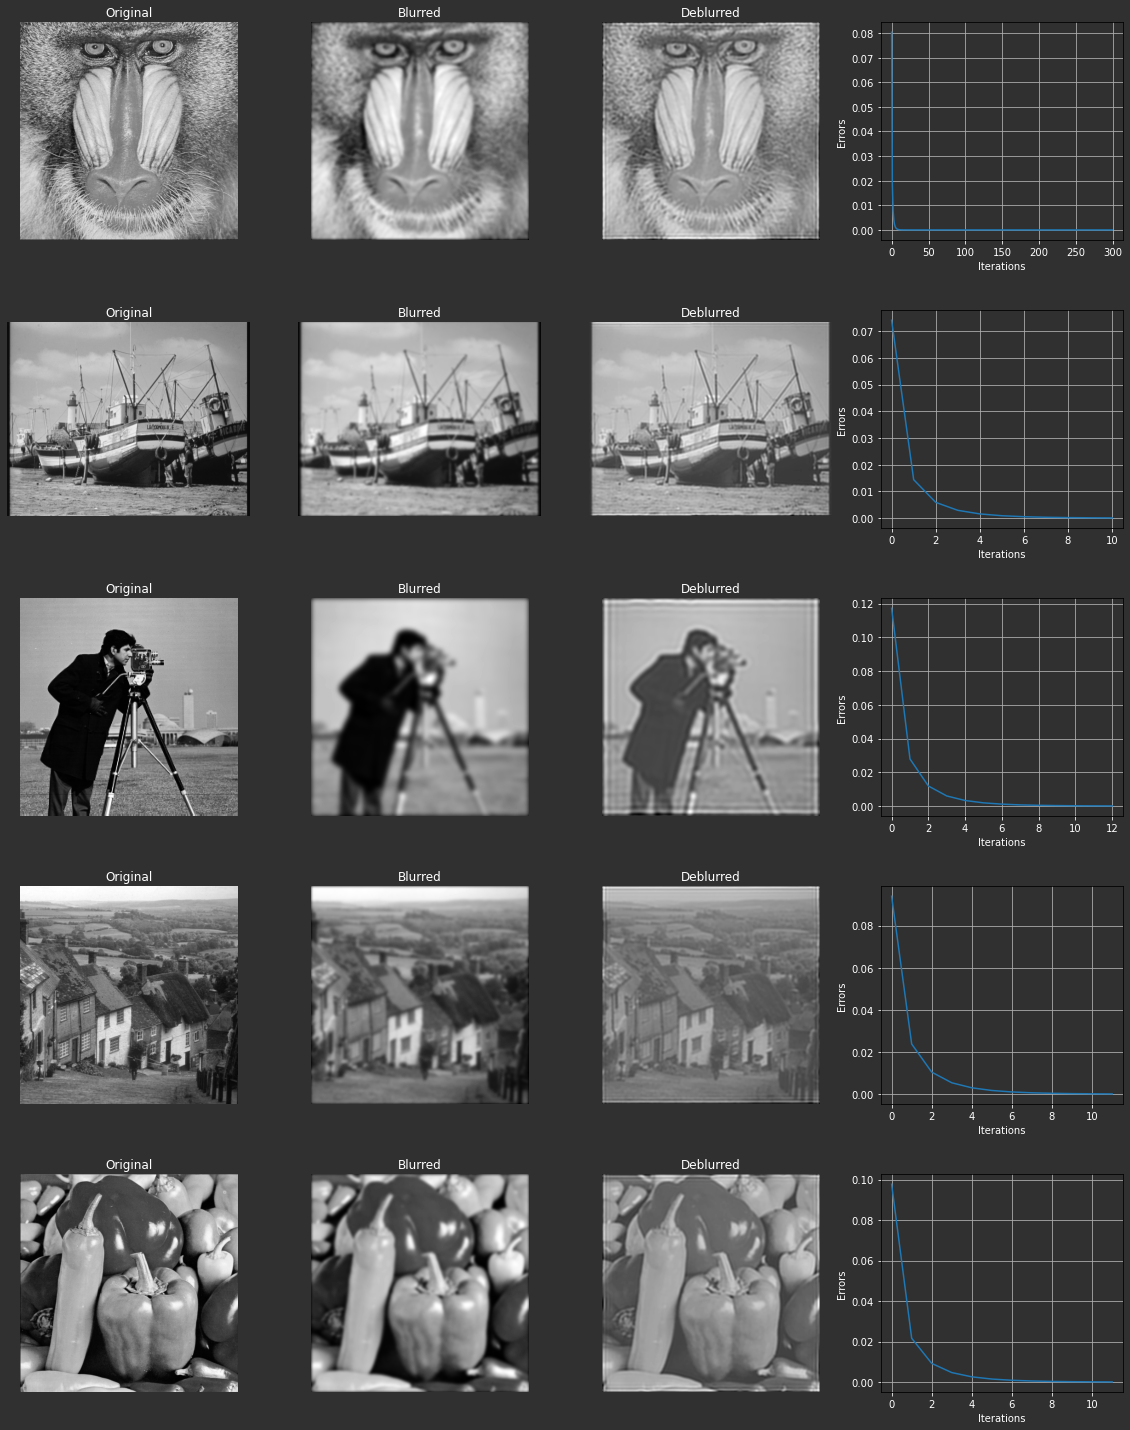

In [87]:
figure = matplotlib.pyplot.figure(figsize=(20, 20))
subfigure = figure.subfigures(NB_IMAGES, 1)

for i in range(0, NB_IMAGES):

    original = imgs_original[i]
    blurred = imgs_blurred[i]
    deblurred = imgs_blurred_results[i]

    ax = subfigure[i].subplots(1, 4)

    ax[0].axis('off')
    ax[0].set_title('Original')
    ax[0].imshow(original, cmap='gray')

    ax[1].axis('off')
    ax[1].set_title('Blurred')
    ax[1].imshow(blurred, cmap='gray')

    ax[2].axis('off')
    ax[2].set_title('Deblurred')
    ax[2].imshow(deblurred, cmap='gray')

    ax[3].axis('on')
    ax[3].grid('on')
    ax[3].set_xlabel('Iterations')
    ax[3].set_ylabel('Errors')
    ax[3].plot(all_errors_blurred[i])

figure.savefig(PATH_RESULTS_PNG / 'all_blurred_results.png')

matplotlib.pyplot.show()


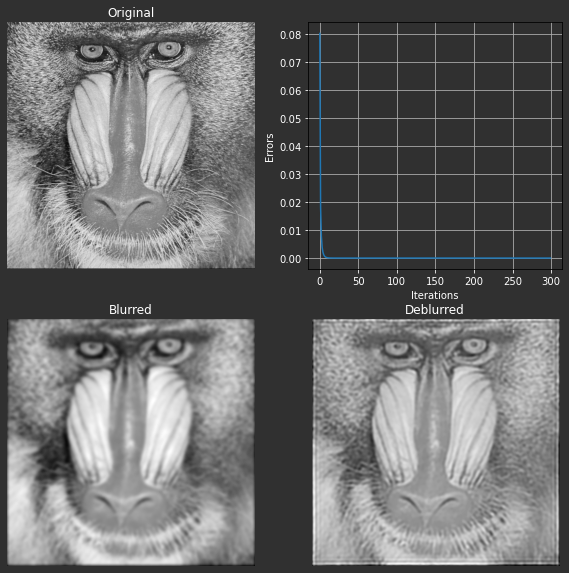

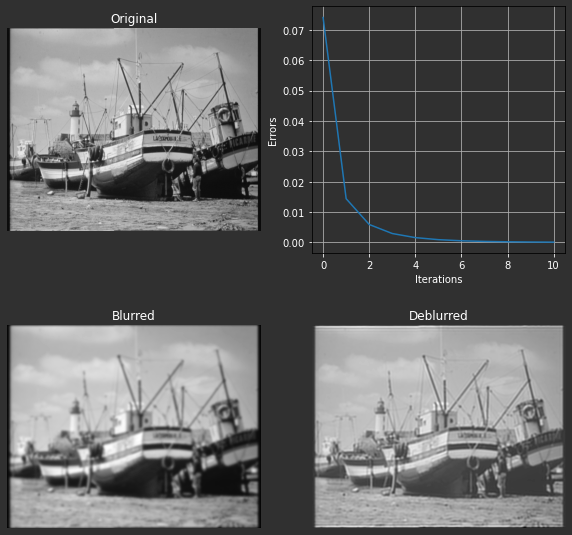

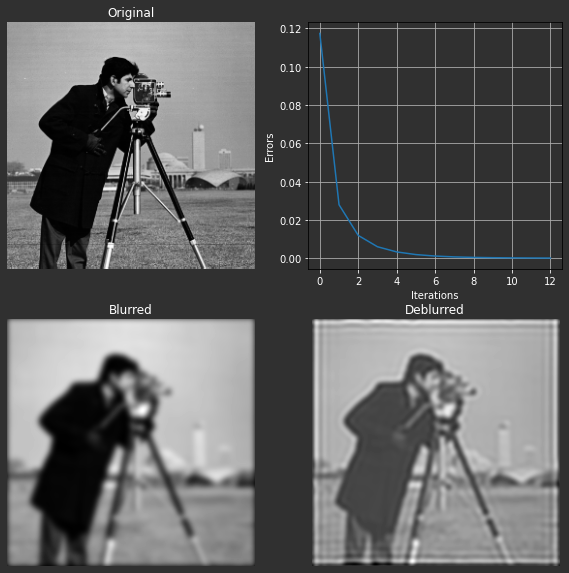

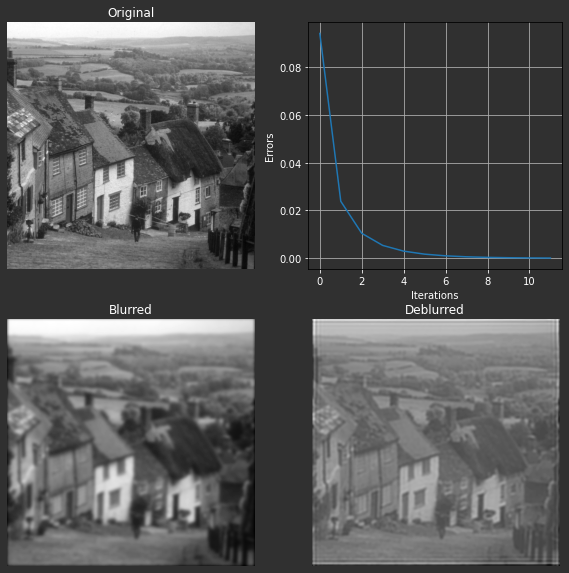

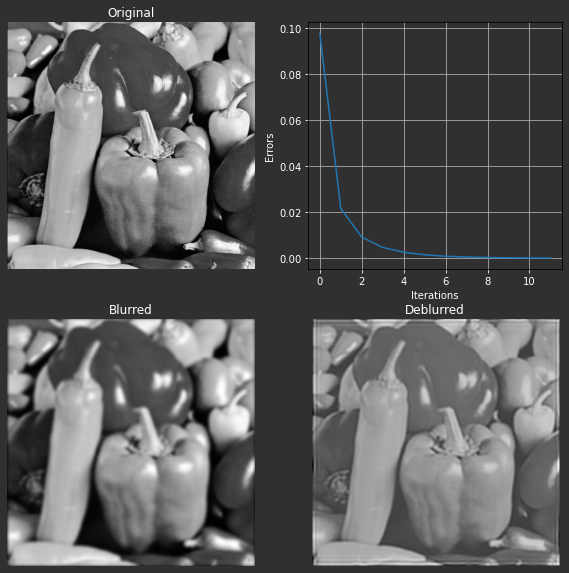

In [88]:
figures = []

for i in range(0, NB_IMAGES):

    filename = filenames_blurred[i].stem

    original = imgs_original[i]
    blurred = imgs_blurred[i]
    deblurred = imgs_blurred_results[i]

    figure = matplotlib.pyplot.figure(
        figsize=(10, 10)
    )

    ax = figure.subplots(2, 2)

    ax[0, 0].axis('off')
    ax[0, 0].set_title('Original')
    ax[0, 0].imshow(original, cmap='gray')

    ax[0, 1].axis('on')
    ax[0, 1].grid('on')
    ax[0, 1].set_xlabel('Iterations')
    ax[0, 1].set_ylabel('Errors')
    ax[0, 1].plot(all_errors_blurred[i])

    ax[1, 0].axis('off')
    ax[1, 0].set_title('Blurred')
    ax[1, 0].imshow(blurred, cmap='gray')

    ax[1, 1].axis('off')
    ax[1, 1].set_title('Deblurred')
    ax[1, 1].imshow(deblurred, cmap='gray')

    figure.savefig(PATH_RESULTS_PNG / (filename +'4x4.png'))

    figures.append(figure)

## Process Noised Images

In [89]:
import lasp.utils

import numpy
import numpy.linalg


all_errors_noised: list[list[float]]= []
imgs_noised_results: list[numpy.ndarray] = []

alphas = [ 200, 200, 200, 200, 200]
betas = [ 1, 1, 1, 1, 1 ]
sigmas = [ 2, 2, 2, 2, 2 ]
iterations = [ 300, 300, 300, 300, 300 ]
tols = [ -1, 10**(-4), 10**(-4), 10**(-4), 10**(-4) ]

for i in range(0, NB_IMAGES):

    filename = filenames_noised[i]
    img = imgs_noised[i]

    errors = []
    res = mumford_shah(
        y=img,
        h=kernel,
        alpha=alphas[i],
        beta=betas[i],
        sigma=sigmas[i],
        nb_iterations=iterations[i],
        tolerance=tols[i],
        error_history=errors
    )
    
    imgs_noised_results.append(res)
    img_name = filename.stem
    all_errors_noised.append(errors)
    dict_errors[img_name] = pandas.Series(errors)

### Check outputs

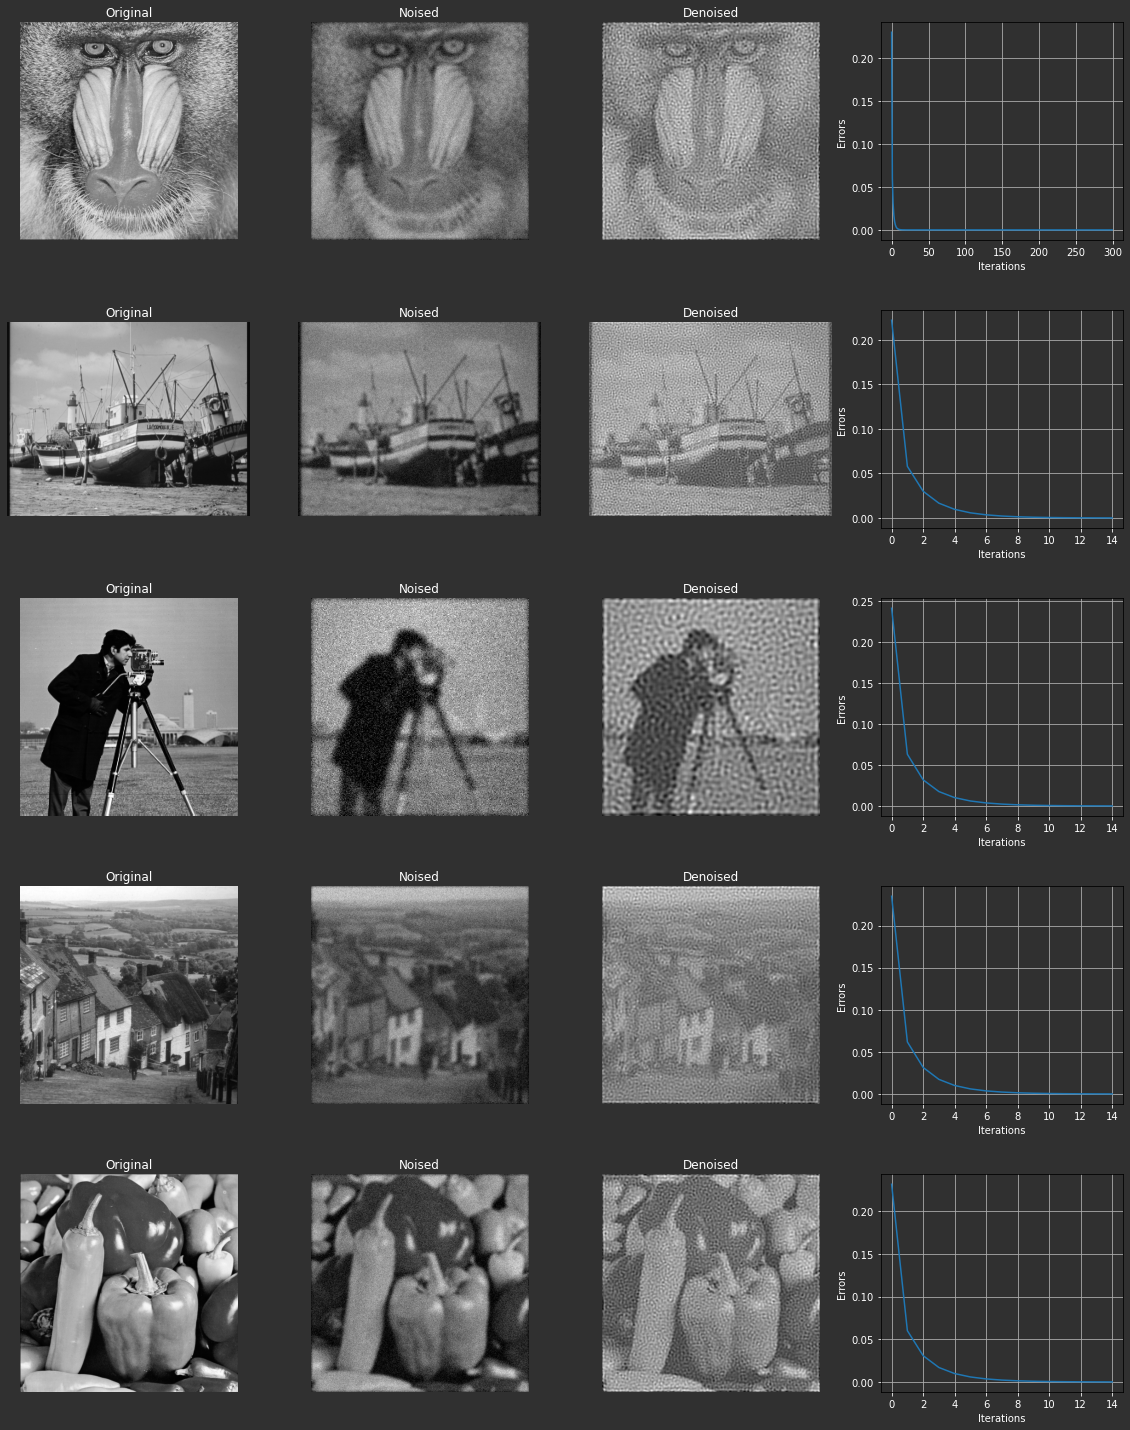

In [90]:
figure = matplotlib.pyplot.figure(figsize=(20, 20))
subfigure = figure.subfigures(NB_IMAGES, 1)

for i in range(0, NB_IMAGES):

    original = imgs_original[i]
    noised = imgs_noised[i]
    denoised = imgs_noised_results[i]

    ax = subfigure[i].subplots(1, 4)

    ax[0].axis('off')
    ax[0].set_title('Original')
    ax[0].imshow(original, cmap='gray')

    ax[1].axis('off')
    ax[1].set_title('Noised')
    ax[1].imshow(noised, cmap='gray')

    ax[2].axis('off')
    ax[2].set_title('Denoised')
    ax[2].imshow(denoised, cmap='gray')

    ax[3].axis('on')
    ax[3].grid('on')
    ax[3].set_xlabel('Iterations')
    ax[3].set_ylabel('Errors')
    ax[3].plot(all_errors_noised[i])

figure.savefig(PATH_RESULTS_PNG / 'all_noised_results.png')

matplotlib.pyplot.show()

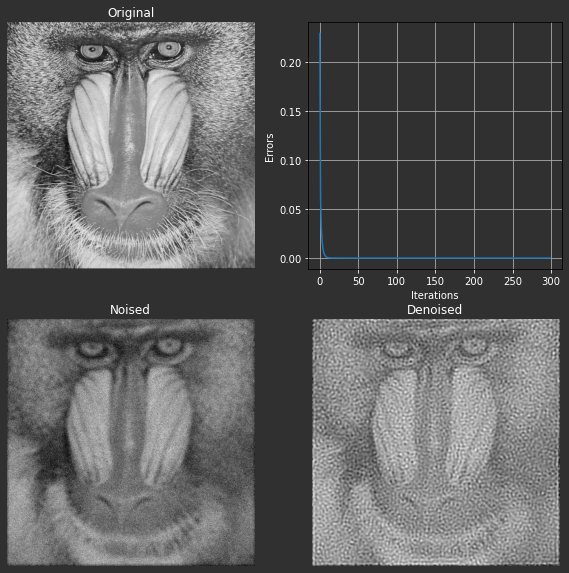

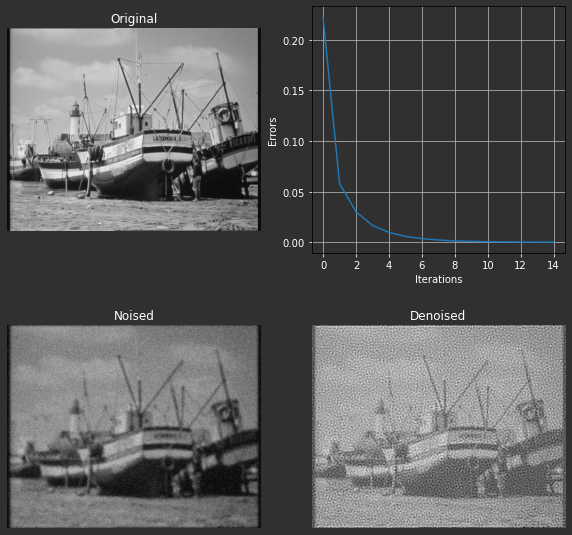

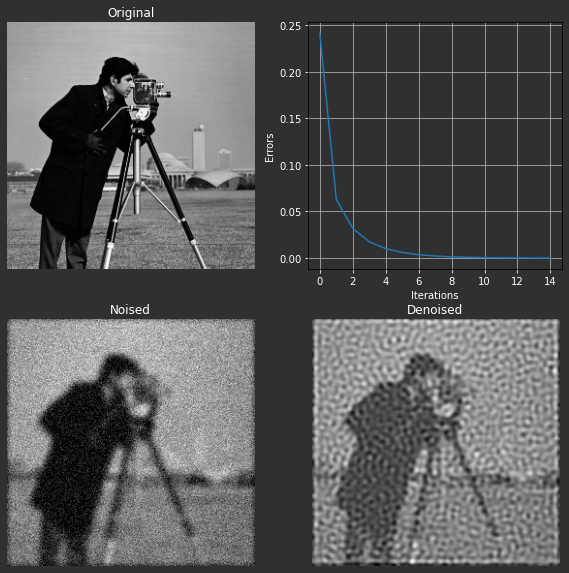

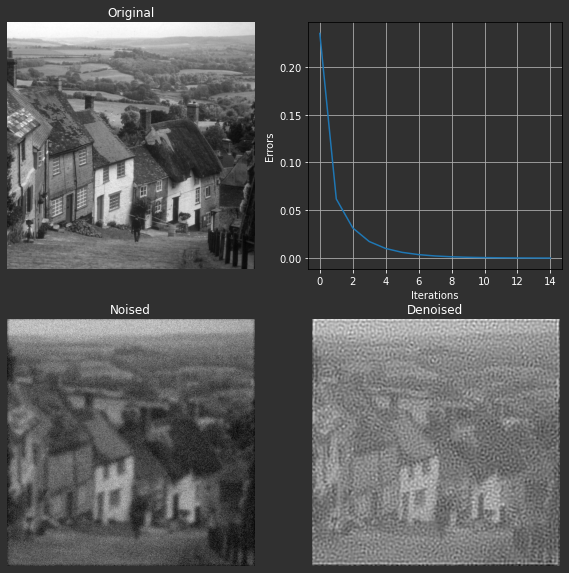

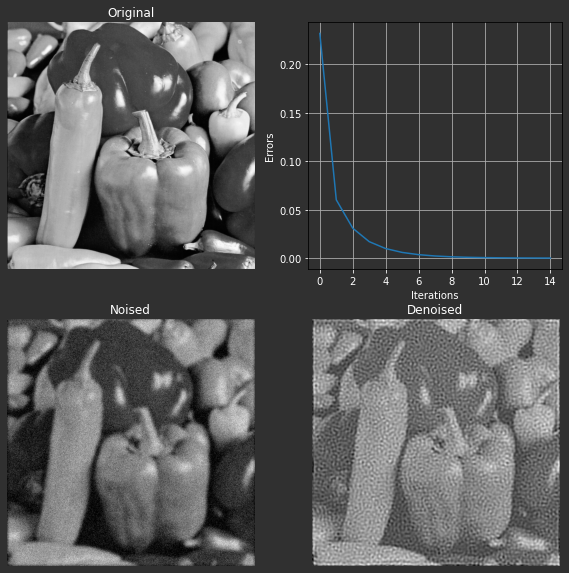

In [91]:
figures = []

for i in range(0, NB_IMAGES):

    filename = filenames_noised[i].stem

    original = imgs_original[i]
    noised = imgs_noised[i]
    denoised = imgs_noised_results[i]

    figure = matplotlib.pyplot.figure(
        figsize=(10, 10)
    )

    ax = figure.subplots(2, 2)

    ax[0, 0].axis('off')
    ax[0, 0].set_title('Original')
    ax[0, 0].imshow(original, cmap='gray')

    ax[0, 1].axis('on')
    ax[0, 1].grid('on')
    ax[0, 1].set_xlabel('Iterations')
    ax[0, 1].set_ylabel('Errors')
    ax[0, 1].plot(all_errors_noised[i])

    ax[1, 0].axis('off')
    ax[1, 0].set_title('Noised')
    ax[1, 0].imshow(noised, cmap='gray')

    ax[1, 1].axis('off')
    ax[1, 1].set_title('Denoised')
    ax[1, 1].imshow(denoised, cmap='gray')

    figure.savefig(PATH_RESULTS_PNG / (filename +'4x4.png'))

    figures.append(figure)

## Print dataframe for errors

In [92]:
df_errors = pandas.DataFrame(dict_errors)
df_errors.to_csv(PATH_RESULTS_CSV / "errors.csv")
df_errors

BaboonBlurred  BoatsBlurred  CameramanBlurred  GoldhillBlurred  \
0     8.033277e-02      0.074045          0.117271         0.093926   
1     1.833990e-02      0.014386          0.027891         0.023804   
2     7.871878e-03      0.005894          0.011880         0.010441   
3     3.921395e-03      0.002918          0.005969         0.005377   
4     2.136717e-03      0.001571          0.003273         0.002989   
..             ...           ...               ...              ...   
295   3.457045e-10           NaN               NaN              NaN   
296   3.427095e-10           NaN               NaN              NaN   
297   3.397604e-10           NaN               NaN              NaN   
298   3.368562e-10           NaN               NaN              NaN   
299   3.339959e-10           NaN               NaN              NaN   

     PeppersBlurred  BaboonNoised  BoatsNoised  CameramanNoised  \
0          0.097725  2.295396e-01     0.222104         0.240865   
1          0.021667  6.035695e-02     0.057993         0.063014   
2          0.009222  3.104430e-02     0.030063         0.031895   
3          0.004691  1.719127e-02     0.016642         0.017569   
4          0.002591  1.002352e-02     0.009699         0.010209   
..              ...           ...          ...              ...   
295             NaN  5.660382e-17          NaN              NaN   
296             NaN  5.665459e-17          NaN              NaN   
297             NaN  5.693634e-17          NaN              NaN   
298             NaN  5.682203e-17          NaN              NaN   
299             NaN  5.694214e-17          NaN              NaN   

     GoldhillNoised  PeppersNoised  
0          0.234747       0.231695  
1          0.061812       0.060115  
2          0.031546       0.030864  
3          0.017368       0.017001  
4          0.010093       0.009871  
..              ...            ...  
295             NaN            NaN  
296             NaN            NaN  
297             NaN            NaN  
298             NaN            NaN  
299             NaN            NaN  

[300 rows x 10 columns]

## Save images

In [93]:
for i in range(0, NB_IMAGES):

    filename_blurred = filenames_blurred[i].stem
    deblurred = imgs_blurred_results[i]
    lasp.io.save(deblurred, PATH_RESULTS_PNG / (filename_blurred + '.png'))
    lasp.io.save(deblurred, PATH_RESULTS_NPY / (filename_blurred + '.npy'))

    filename_noised = filenames_noised[i].stem
    denoised = imgs_noised_results[i]
    lasp.io.save(denoised, PATH_RESULTS_PNG / (filename_noised + '.png'))
    lasp.io.save(denoised, PATH_RESULTS_NPY / (filename_noised + '.npy'))
